# **Understanding the Problem**
The objective of the study is to predict a crash severity on traffic. Since the project involved is to labelize the severity of the given accident based on information available, it will be formulated as **classification** problem. Model performance will be evaluated using accuracy and sparse categorical crossentropy metrics.


# **Data Acquisition and Insights**
The data involved in the study is from [US Accidents (2016 - 2023)](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?select=US_Accidents_March23.csv). It contains accident data collected from February 2016 to March 2023 for the Contiguous United States. The features and description of features of the data are provided [here](https://smoosavi.org/datasets/us_accidents). In this section, statistical descriptions such as mean, standard deviation, min, max, and median of variables will be analyzed to understand the trend of the data. Next, GIS Spatial pattern analysis, histograms for data distributions of numerical variables, pie-charts for data distribution of categorical variables, and a look through of correlation of the variables using heatmaps will be performed to get the feel of the type of data being dealt.
Additionally, new features such as seasonal crash frequency will be engineered to understand the driver’s expectancy from a curve design during a particular season. Finally, the provided data will be split into training and testing subsets (80%-20%) to ensure
reliable model evaluation. Here, we will be implementing stratified splitting. This is because, normal splitting does not guarantee the preservataion of distribution of classes in both train and test sets.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Crash severity

/content/gdrive/.shortcut-targets-by-id/1PPTdMShCmN_ebwQDrXakKkI4ggw-4Ayf/Crash severity


In [ ]:
import pandas as pd

In [ ]:
chunksize = 10000
chunks = pd.read_csv("US_Accidents_March23.csv", chunksize=chunksize)
data = pd.concat(chunks, ignore_index=True)

In [ ]:
#Free memory by deleting variables from system memory
for var in list(globals().keys()):
  if var != 'data' and not var.startswith('__'):
    del globals()[var]

import gc
gc.collect()
print(globals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '__', '___', 'data', 'var', 'gc'])


In [ ]:
print(f"Total length of data: {len(data)}")
print(data.info())

Total length of data: 7728394
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          f

Statistical Description 1: Presence of null values on the data is observed

In [ ]:
print(data.isnull().sum())

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      

Statistical Description 2: Mean, Medium, Max, and other statistical parameters

In [ ]:
print(data.describe())

           Severity     Start_Lat     Start_Lng       End_Lat       End_Lng  \
count  7.728394e+06  7.728394e+06  7.728394e+06  4.325632e+06  4.325632e+06   
mean   2.212384e+00  3.620119e+01 -9.470255e+01  3.626183e+01 -9.572557e+01   
std    4.875313e-01  5.076079e+00  1.739176e+01  5.272905e+00  1.810793e+01   
min    1.000000e+00  2.455480e+01 -1.246238e+02  2.456601e+01 -1.245457e+02   
25%    2.000000e+00  3.339963e+01 -1.172194e+02  3.346207e+01 -1.177543e+02   
50%    2.000000e+00  3.582397e+01 -8.776662e+01  3.618349e+01 -8.802789e+01   
75%    2.000000e+00  4.008496e+01 -8.035368e+01  4.017892e+01 -8.024709e+01   
max    4.000000e+00  4.900220e+01 -6.711317e+01  4.907500e+01 -6.710924e+01   

       Distance(mi)  Temperature(F)  Wind_Chill(F)   Humidity(%)  \
count  7.728394e+06    7.564541e+06   5.729375e+06  7.554250e+06   
mean   5.618423e-01    6.166329e+01   5.825105e+01  6.483104e+01   
std    1.776811e+00    1.901365e+01   2.238983e+01  2.282097e+01   
min    0.000000e

So, there are several features with null values. Since there are about 3.5 millions of End_Lat and End_Lng null, we will use only Start_Lng and Start_Lng to visualize the location of start of accident.

**Limitation in this project**: Implementation of Folium would have been effective for analysis. However, due to limited free RAM resources, matplotlib is being used.

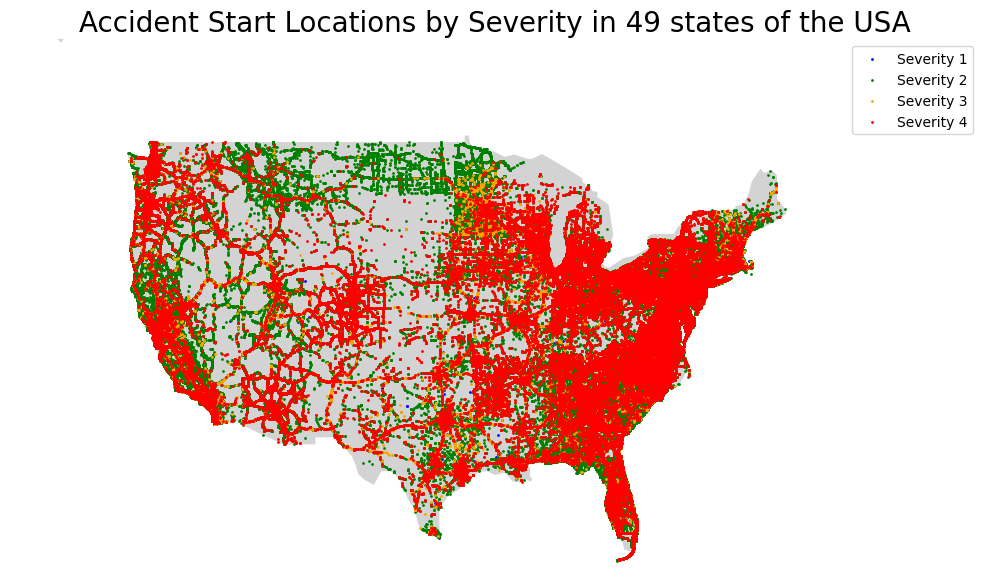

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
usa = gpd.read_file('Country_Maps/ne_110m_admin_0_countries.shp')
usa = usa[usa['NAME'] == 'United States of America']


fig, ax = plt.subplots(figsize=(10, 10))
usa.plot(ax=ax, color='lightgrey', aspect=1.5)
severity_colors = {1: 'blue', 2: 'green', 3: 'orange', 4: 'red'}

for severity in sorted(data['Severity'].unique()):
    subset = data[data['Severity'] == severity]
    plt.scatter(subset['Start_Lng'], subset['Start_Lat'], label=f'Severity {severity}', color=severity_colors[severity], s = 1)


plt.xlim(-135, -50)
plt.ylim(24, 55)
ax.axis('off')
plt.title('Accident Start Locations by Severity in 49 states of the USA', fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('accident_severity_plot.png', dpi=300, bbox_inches='tight')
plt.show()

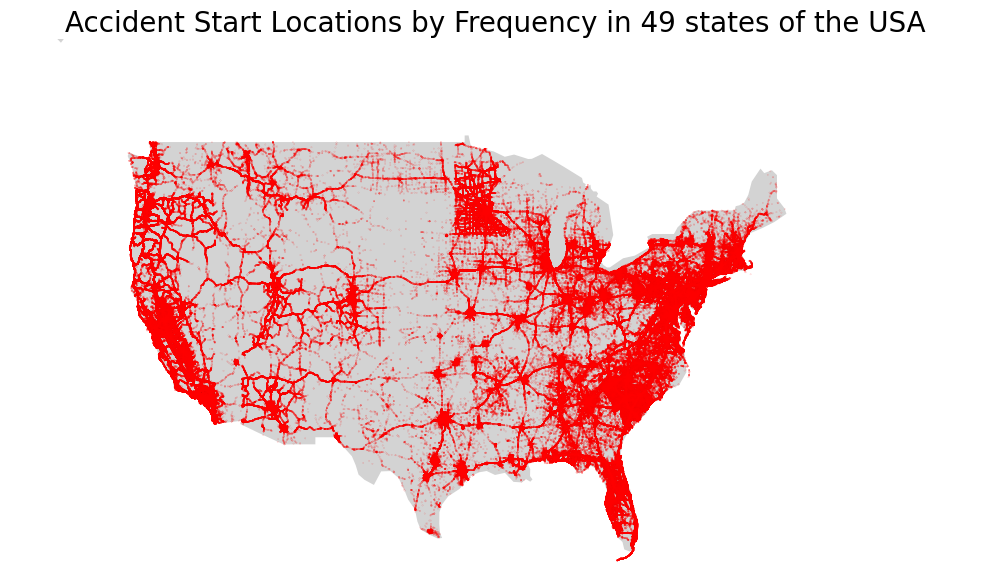

In [ ]:
usa = gpd.read_file('Country_Maps/ne_110m_admin_0_countries.shp')
usa = usa[usa['NAME'] == 'United States of America']
fig, ax = plt.subplots(figsize=(10, 10))
usa.plot(ax=ax, color='lightgrey', aspect=1.5)
frequency = data.groupby(['Start_Lat', 'Start_Lng']).size().reset_index(name='Frequency')
plt.scatter(frequency['Start_Lng'], frequency['Start_Lat'], s=frequency['Frequency']*0.01, color='red', alpha=0.6)
plt.xlim(-135, -50)
plt.ylim(24, 55)
ax.axis('off')
plt.title('Accident Start Locations by Frequency in 49 states of the USA', fontsize=20)
plt.tight_layout()
plt.savefig('accident_frequency_plot.png', dpi=300, bbox_inches='tight')
plt.show()

**Limitation in this project**: Lack of system memory constrained the study from developing further visualizations such as histographs, pie-charts, and heatmaps.

Now, let's remove unnecessary attributes, and feature engineer new column to capture seasonal information

In [ ]:
unnecessary_cols = ['ID','Start_Lat','Start_Lng','End_Lat','End_Lng','Description','Street','City','County','State','Zipcode','Country','Timezone','Airport_Code','Weather_Timestamp','Source','End_Time']
data = data.drop(unnecessary_cols,axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Severity               int64  
 1   Start_Time             object 
 2   Distance(mi)           float64
 3   Temperature(F)         float64
 4   Wind_Chill(F)          float64
 5   Humidity(%)            float64
 6   Pressure(in)           float64
 7   Visibility(mi)         float64
 8   Wind_Direction         object 
 9   Wind_Speed(mph)        float64
 10  Precipitation(in)      float64
 11  Weather_Condition      object 
 12  Amenity                bool   
 13  Bump                   bool   
 14  Crossing               bool   
 15  Give_Way               bool   
 16  Junction               bool   
 17  No_Exit                bool   
 18  Railway                bool   
 19  Roundabout             bool   
 20  Station                bool   
 21  Stop                   bool   
 22  Traffic_Calming   

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9,10,11]:
        return 'Fall'
    else:
      raise ValueError("No month like this exist")

In [ ]:
import pandas as pd
data['Start_Time'] = pd.to_datetime(data['Start_Time'], format='mixed')
data['Season'] = data['Start_Time'].dt.month.map(get_season)

In [ ]:
data = data.drop(['Start_Time'],axis=1)

Here, we will be implementing stratified splitting. This is because, normal splitting does not guarantee the preservataion of distribution of classes in both train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split
y = data['Severity']
X = data.drop(['Severity'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set target distribution:\n", y_train.value_counts(normalize=True))
print("Testing set target distribution:\n", y_test.value_counts(normalize=True))

Training set target distribution:
 Severity
2    0.796670
3    0.168125
4    0.026488
1    0.008717
Name: proportion, dtype: float64
Testing set target distribution:
 Severity
2    0.796670
3    0.168125
4    0.026488
1    0.008717
Name: proportion, dtype: float64


Now, since we no longer anything except X_train, y_train, X_test, y_test; delete every variables except for them to free memory

In [ ]:
vars_to_keep = ['X_train', 'X_test', 'y_train', 'y_test']
for var in list(globals().keys()):
  if var not in vars_to_keep and not var.startswith('__'):
    del globals()[var]

import gc
gc.collect()
print(globals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '__', '___', 'X_train', 'X_test', 'y_train', 'y_test', 'var', 'gc'])


# **Data Preprocessing**
The exclusion of other irrelevant variables and handling of missing data for relevant variables. Multi-class data will be encoded using One Hot Encoding while binary-class data will be encoded using Label Encoder. Scaling of continuous data will be done using Standard scaling.


In [ ]:
import numpy as np

In [ ]:
#Remember, test data is something we assume we don't have access to, which is why splitting is always done before scaling. Also, the handling of missing data can be done with mean values for regression data, however, the mean should be from train dataset
print(X_train.isnull().sum())

Distance(mi)                   0
Temperature(F)            131067
Wind_Chill(F)            1599861
Humidity(%)               139277
Pressure(in)              112568
Visibility(mi)            141702
Wind_Direction            140319
Wind_Speed(mph)           457114
Precipitation(in)        1763465
Weather_Condition         138831
Amenity                        0
Bump                           0
Crossing                       0
Give_Way                       0
Junction                       0
No_Exit                        0
Railway                        0
Roundabout                     0
Station                        0
Stop                           0
Traffic_Calming                0
Traffic_Signal                 0
Turning_Loop                   0
Sunrise_Sunset             18685
Civil_Twilight             18685
Nautical_Twilight          18685
Astronomical_Twilight      18685
Season                         0
dtype: int64


Null values in Regression data will be replaced by mean value of the corresponding training column. The NaNs in categorical columns will be handled during encoding. There is no NaNs in target variable.

In [ ]:
reg_cols_to_imp = ['Distance(mi)','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']
train_mean_value = {}
for col in reg_cols_to_imp:
  train_mean_value[col] = X_train[col].mean()
  X_train[col].fillna(train_mean_value[col], inplace=True)
#Now we will use X_train mean to impute missing value in X_test
for col in reg_cols_to_imp:
  X_test[col].fillna(train_mean_value[col], inplace=True)

<ipython-input-19-a3728bf8c82a>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(train_mean_value[col], inplace=True)
<ipython-input-19-a3728bf8c82a>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [ ]:
print(X_train.isnull().sum())

Distance(mi)                  0
Temperature(F)                0
Wind_Chill(F)                 0
Humidity(%)                   0
Pressure(in)                  0
Visibility(mi)                0
Wind_Direction           140319
Wind_Speed(mph)               0
Precipitation(in)             0
Weather_Condition        138831
Amenity                       0
Bump                          0
Crossing                      0
Give_Way                      0
Junction                      0
No_Exit                       0
Railway                       0
Roundabout                    0
Station                       0
Stop                          0
Traffic_Calming               0
Traffic_Signal                0
Turning_Loop                  0
Sunrise_Sunset            18685
Civil_Twilight            18685
Nautical_Twilight         18685
Astronomical_Twilight     18685
Season                        0
dtype: int64


In [ ]:
print(X_test.isnull().sum())

Distance(mi)                 0
Temperature(F)               0
Wind_Chill(F)                0
Humidity(%)                  0
Pressure(in)                 0
Visibility(mi)               0
Wind_Direction           34887
Wind_Speed(mph)              0
Precipitation(in)            0
Weather_Condition        34628
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset            4561
Civil_Twilight            4561
Nautical_Twilight         4561
Astronomical_Twilight     4561
Season                       0
dtype: int64


In [ ]:
cat_cols = [cols for cols in X_train.columns if cols not in reg_cols_to_imp]
print(X_train[cat_cols].nunique())

Wind_Direction            24
Weather_Condition        141
Amenity                    2
Bump                       2
Crossing                   2
Give_Way                   2
Junction                   2
No_Exit                    2
Railway                    2
Roundabout                 2
Station                    2
Stop                       2
Traffic_Calming            2
Traffic_Signal             2
Turning_Loop               1
Sunrise_Sunset             2
Civil_Twilight             2
Nautical_Twilight          2
Astronomical_Twilight      2
Season                     4
dtype: int64


From this info, we know that Wind_Direction, Weather_Condition, and Season are multi-class data for which one-hot encoding will be performed and since other categorical data are binary, label encoder will be performed except for Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, and Astronomical_Twilight which even though are binary contain NaNs, so these four columns will also be treated through one-hot encoding.

**Note**: Turning Loop has only one class i.e. False, so this will be dropped in both of our training and testing data

In [ ]:
X_train.drop(['Turning_Loop'],axis=1,inplace=True)
X_test.drop(['Turning_Loop'],axis=1,inplace=True)

In [ ]:
import pandas as pd

def one_hot_enc(df,columns,prefixes):
  df = df.copy()
  for column, prefix in zip(columns,prefixes):
    dummies = pd.get_dummies(df[column],prefix=prefix)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(column,axis=1)
  return df.astype(np.float16)

In [ ]:
multi_class = ['Wind_Direction','Weather_Condition','Season','Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
prefix = ['WD','WC','S','SS','CT','NT','AT']
X_train, X_test = [one_hot_enc(x,multi_class,prefix) for x in [X_train,X_test]]

Remaining binary class are bool, so converting bool to int would just do the trick.

In [ ]:
binary_class = [cols for cols in cat_cols if cols not in multi_class]
binary_class.remove('Turning_Loop')
X_train[binary_class] = X_train[binary_class].astype(np.float16)
X_test[binary_class] = X_test[binary_class].astype(np.float16)

In [ ]:
#Free memory once again
vars_to_keep = ['X_train', 'X_test', 'y_train', 'y_test']
for var in list(globals().keys()):
  if var not in vars_to_keep and not var.startswith('__'):
    del globals()[var]

import gc
gc.collect()
print(globals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '__', '___', 'X_train', 'X_test', 'y_train', 'y_test', 'var', 'gc'])


In [ ]:
#Scaling
from sklearn.preprocessing import StandardScaler
y_train, y_test = y_train - 1, y_test - 1
scaler = StandardScaler()
reg_cols = ['Distance(mi)','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']
X_train[reg_cols] = scaler.fit_transform(X_train[reg_cols])
X_test[reg_cols] = scaler.transform(X_test[reg_cols])

In [ ]:
#Free memory once again
vars_to_keep = ['X_train', 'X_test', 'y_train', 'y_test']
for var in list(globals().keys()):
  if var not in vars_to_keep and not var.startswith('__'):
    del globals()[var]

import gc
gc.collect()
print(globals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '__', '___', 'X_train', 'X_test', 'y_train', 'y_test', 'var', 'gc'])


In [ ]:
#Some columns are missing in test from train, this is because test never had the same Weather Conditions as in train, so filling up missing columns with nulls in order
X_train_cols = set(X_train.columns)
X_test_cols = set(X_test.columns)
for col in (X_train_cols-X_test_cols):
  X_test[col] = 0
X_test = X_test[X_train.columns]

In [ ]:
print(X_train.shape)
print(X_test.shape)

(6182715, 197)
(1545679, 197)


In [ ]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)